In [87]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from src import mef_test
import sklearn
from src import functions
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
train = functions.load_train_add_target_df()
#Creating the status column for numerically transformed status_group
train['status'] = train.status_group.replace(functions.numeric_status_group())

train = functions.combine_extraction(train)
train = functions.combine_managements(train)
train = functions.combine_installer_funder(train)
train = functions.combine_waterpoint(train)
train = functions.clean_permit(train)

In [89]:
new_df = train

In [90]:
def average_prediction(construction_year):
    if type(construction_year) == str:
        decade_split = construction_year.split('-')
        return pd.Series(decade_split).map(int).mean()
    else:
        return construction_year

    

In [91]:
new_df['decade'] = new_df['construction_year'].map(functions.bin_year)

non_zeros = new_df[new_df['construction_year']>0]
decades = ['2000-2010',
'1990-2000',
'1980-1990',
'2010-2020',
'1970-1980',
'1960-1970']
for decade in decades:
    non_zeros[decade] = non_zeros['decade'].map(lambda val: functions.create_decade_columns(val, decade))

non_zeros = non_zeros.loc[:,['construction_year']]

<ipython-input-91-be43fff973e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zeros[decade] = non_zeros['decade'].map(lambda val: functions.create_decade_columns(val, decade))


In [92]:
zeros = new_df[new_df['construction_year']==0]
zeros_index = zeros.index
zeros = zeros.reset_index().drop("index", axis=1)

In [93]:
zeros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20709 entries, 0 to 20708
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            20709 non-null  int64  
 1   amount_tsh                    20709 non-null  float64
 2   date_recorded                 20709 non-null  object 
 3   gps_height                    20709 non-null  int64  
 4   longitude                     20709 non-null  float64
 5   latitude                      20709 non-null  float64
 6   wpt_name                      20709 non-null  object 
 7   num_private                   20709 non-null  int64  
 8   basin                         20709 non-null  object 
 9   subvillage                    20348 non-null  object 
 10  region                        20709 non-null  object 
 11  region_code                   20709 non-null  int64  
 12  district_code                 20709 non-null  int64  
 13  l

In [94]:
zeros_clean = zeros.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                   'management_group', 'permit', 'district_code']]

In [95]:
funder_installer_ohe = pickle.load(open('../src/funder_installer_ohe.sav', 'rb'))
extraction_type_group_class_ohe = pickle.load(open('../src/extraction_type_group_class_ohe.sav', 'rb'))
scheme_management_management_ohe = pickle.load(open('../src/scheme_management_management_ohe.sav', 'rb'))
management_group_ohe = pickle.load(open('../src/management_group_ohe.sav', 'rb'))
source_type_ohe = pickle.load(open('../src/source_type_ohe.sav', 'rb'))
source_ohe = pickle.load(open('../src/source_ohe.sav', 'rb'))
waterpoint_type_group_ohe = pickle.load(open('../src/waterpoint_type_group_ohe.sav', 'rb'))
permit_ohe = pickle.load(open('../src/permit_ohe.sav', 'rb'))
basin_ohe = pickle.load(open('../src/basin_ohe.sav', 'rb'))
district_code_ohe = pickle.load(open('../src/district_code_ohe.sav', 'rb'))
region_code_ohe = pickle.load(open('../src/region_code_ohe.sav', 'rb'))

In [96]:
X_test_all_features = zeros_clean.copy().reset_index().drop("index", axis=1)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, 'funder/installer', funder_installer_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "extraction_type/group/class", extraction_type_group_class_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "scheme_management/management", scheme_management_management_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "management_group", management_group_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "source_type", source_type_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "source", source_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "waterpoint_type/group", waterpoint_type_group_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "permit", permit_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "basin", basin_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "district_code", district_code_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "region_code", region_code_ohe)

In [97]:
model = pickle.load(open('../src/year_predictor.sav', 'rb'))

predictions_ = model.predict(X_test_all_features)
prediction_df = pd.DataFrame(predictions_, index=zeros_index, columns=['construction_year'])

predictions_

array(['2010-2020', '1990-2000', '2000-2010', ..., '2010-2020',
       '2000-2010', '2010-2020'], dtype=object)

In [98]:
full_df = pd.concat([non_zeros, prediction_df])
full_df.sort_index(inplace=True)

full_df['construction_year'] = full_df['construction_year'].map(average_prediction)

new_df = new_df.drop('construction_year', axis=1).merge(full_df, left_index=True, right_index=True)
new_df.drop('decade', axis=1, inplace=True)


In [99]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            59400 non-null  int64  
 1   amount_tsh                    59400 non-null  float64
 2   date_recorded                 59400 non-null  object 
 3   gps_height                    59400 non-null  int64  
 4   longitude                     59400 non-null  float64
 5   latitude                      59400 non-null  float64
 6   wpt_name                      59400 non-null  object 
 7   num_private                   59400 non-null  int64  
 8   basin                         59400 non-null  object 
 9   subvillage                    59029 non-null  object 
 10  region                        59400 non-null  object 
 11  region_code                   59400 non-null  int64  
 12  district_code                 59400 non-null  int64  
 13  l

In [100]:
full_df.construction_year.describe()

count    59400.000000
mean      1997.828316
std         12.106569
min       1960.000000
25%       1992.000000
50%       2002.000000
75%       2006.000000
max       2015.000000
Name: construction_year, dtype: float64

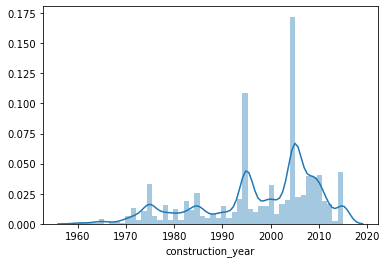

In [101]:
sns.distplot(full_df.construction_year)

In [89]:
def average_prediction(construction_year):
    if type(construction_year) == str:
        decade_split = construction_year.split('-')
        return pd.Series(decade_split).map(int).mean()
    else:
        return construction_year

    

In [89]:
df['decade'] = df['construction_year'].map(functions.bin_year)

non_zeros = df[df['construction_year']>0]
decades = ['2000-2010',
'1990-2000',
'1980-1990',
'2010-2020',
'1970-1980',
'1960-1970']
for decade in decades:
    non_zeros[decade] = non_zeros['decade'].map(lambda val: functions.create_decade_columns(val, decade))

non_zeros = non_zeros.loc[:,['construction_year']]

zeros = df[df['construction_year']==0]
zeros_index = zeros.index
zeros = zeros.reset_index().drop("index", axis=1)

zeros.info()

zeros_clean = zeros.loc[:,['waterpoint_type/group', 'scheme_management/management', 'basin', 'region_code', 
                    'funder/installer', 'extraction_type/group/class',  'source', 'source_type', 
                   'management_group', 'permit', 'district_code']]

funder_installer_ohe = pickle.load(open('../src/funder_installer_ohe.sav', 'rb'))
extraction_type_group_class_ohe = pickle.load(open('../src/extraction_type_group_class_ohe.sav', 'rb'))
scheme_management_management_ohe = pickle.load(open('../src/scheme_management_management_ohe.sav', 'rb'))
management_group_ohe = pickle.load(open('../src/management_group_ohe.sav', 'rb'))
source_type_ohe = pickle.load(open('../src/source_type_ohe.sav', 'rb'))
source_ohe = pickle.load(open('../src/source_ohe.sav', 'rb'))
waterpoint_type_group_ohe = pickle.load(open('../src/waterpoint_type_group_ohe.sav', 'rb'))
permit_ohe = pickle.load(open('../src/permit_ohe.sav', 'rb'))
basin_ohe = pickle.load(open('../src/basin_ohe.sav', 'rb'))
district_code_ohe = pickle.load(open('../src/district_code_ohe.sav', 'rb'))
region_code_ohe = pickle.load(open('../src/region_code_ohe.sav', 'rb'))

X_test_all_features = zeros_clean.copy().reset_index().drop("index", axis=1)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, 'funder/installer', funder_installer_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "extraction_type/group/class", extraction_type_group_class_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "scheme_management/management", scheme_management_management_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "management_group", management_group_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "source_type", source_type_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "source", source_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "waterpoint_type/group", waterpoint_type_group_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "permit", permit_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "basin", basin_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "district_code", district_code_ohe)
X_test_all_features = functions.encode_and_concat_feature(X_test_all_features, "region_code", region_code_ohe)

model = pickle.load(open('../src/year_predictor.sav', 'rb'))

predictions_ = model.predict(X_test_all_features)
prediction_df = pd.DataFrame(predictions_, index=zeros_index, columns=['construction_year'])

predictions_

full_df = pd.concat([non_zeros, prediction_df])
full_df.sort_index(inplace=True)

full_df['construction_year'] = full_df['construction_year'].map(average_prediction)

new_df = new_df.drop('construction_year', axis=1).merge(full_df, left_index=True, right_index=True)
new_df.drop('decade', axis=1, inplace=True)

return new_df